In [260]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

Let's start with defining some functionality

In [289]:
def get_choice(row):
    
    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):
    
    """
    Simulates stim-coded data.
    """
    
    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim

def fit_subject(data, quantiles):
    
    """
    Simulates stim-coded data.
    """
    
    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def summary_plot(df, df_sim=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    # remove NaNs:
    df = df.loc[~pd.isna(df.rt),:]
    if df_sim is not None:
        df_sim = df_sim.loc[~pd.isna(df_sim.rt),:]
    
    fig = plt.figure(figsize=(10,2.5))
    
    # rt distributions correct vs error:
    ax = fig.add_subplot(1,4,1)
    ax.hist(df.loc[(df.correct==0), 'rt']*-1.0, bins=10, density=True, 
            histtype='stepfilled', color='red', alpha=0.5, label='error')
    ax.hist(df.loc[(df.correct==1), 'rt'], bins=10, density=True, 
            histtype='stepfilled', color='green', alpha=0.5, label='correct')    
    if df_sim is not None:
        ax.hist(df_sim.loc[(df_sim.correct==0), 'rt']*-1.0, bins=10, density=True, 
                histtype='step', color='k', alpha=1, label=None)
        ax.hist(df_sim.loc[(df_sim.correct==1), 'rt'], bins=10, density=True, 
                histtype='step', color='k', alpha=1, label=None)    
    ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
    ax.set_xlabel('RT (s)')
    ax.set_ylabel('Trials (prob. dens.)')
    ax.legend(loc=1)

    # condition accuracy plots:
    ax = fig.add_subplot(1,4,2)
    df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
    d = df.groupby(['rt_bin']).mean().reset_index()
    ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
    if df_sim is not None:
        df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
        d = df_sim.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_ylim(0, 1)
    ax.set_title('Conditional accuracy')
    ax.set_xlabel('RT (quantiles)')
    ax.set_ylabel('P(correct)')
    
    # rt distributions response 1 vs 0:
    ax = fig.add_subplot(1,4,3)
    ax.hist(df.loc[(df.response==0), 'rt']*-1.0, bins=10, density=True, 
            histtype='stepfilled', color='cyan', alpha=0.5, label='resp. 0')
    ax.hist(df.loc[(df.response==1), 'rt'], bins=10, density=True, 
            histtype='stepfilled', color='magenta', alpha=0.5, label='resp. 1')    
    if df_sim is not None:
        ax.hist(df_sim.loc[(df_sim.response==0), 'rt']*-1.0, bins=10, density=True, 
                histtype='step', color='k', alpha=1, label=None)
        ax.hist(df_sim.loc[(df_sim.response==1), 'rt'], bins=10, density=True, 
                histtype='step', color='k', alpha=1, label=None)    
    ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
    ax.set_xlabel('RT (s)')
    ax.set_ylabel('Trials (prob. dens.)')
    ax.legend(loc=1)
    
    # condition response plots:
    ax = fig.add_subplot(1,4,4)
    df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
    d = df.groupby(['rt_bin']).mean().reset_index()
    ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
    if df_sim is not None:
        df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
        d = df_sim.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_ylim(0,1)
    ax.set_title('Conditional response')
    ax.set_xlabel('RT (quantiles)')
    ax.set_ylabel('P(bias)')
    
    sns.despine(offset=10, trim=True)
    plt.tight_layout()

    return fig

Let's simulate our own data, so we know what the fitting procedure should converge on:

In [279]:
# settings
go_nogo = True # should we put all RTs for one choice alternative to NaN (go-no data)?
n_subjects = 4
trials_per_level = 10000

# parameters:
params0 = {'cond':0, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':-0.2, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}

# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)

# combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"]==0, 'rt'] = np.NaN

Fit using the g-quare method.

In [280]:
# fit chi-square:
quantiles = [.1, .3, .5, .7, .9]
params_fitted = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles) 
                                                      for data in df_emp.groupby('subj_idx')))
print(params_fitted.head())

       a(0)      a(1)      v(0)      v(1)      t(0)      t(1)  z_trans(0)  \
0  1.958094  1.978094  0.507206  0.484791  0.267853  0.305447   -0.189052   
1  1.984882  1.990543  0.498140  0.492893  0.287255  0.295405   -0.064292   
2  2.003489  2.029403  0.497277  0.489393  0.314356  0.321966    0.069406   
3  1.979266  2.013820  0.498107  0.492360  0.304581  0.290364   -0.009812   

   z_trans(1)      z(0)      z(1)     dc(0)     dc(1)            bic  \
0   -0.009288  0.452877  0.497678 -0.092293  0.199874  116671.043459   
1   -0.028185  0.483932  0.492954 -0.183275  0.223522  116032.187521   
2    0.156847  0.517345  0.539132 -0.247799  0.110298  115676.033437   
3   -0.025558  0.497547  0.493611 -0.196986  0.222437  116318.580236   

      likelihood     penalty  
0 -116543.883842  127.159617  
1 -115905.027904  127.159617  
2 -115548.873820  127.159617  
3 -116191.420619  127.159617  


In [281]:
params_fitted.drop(['bic', 'likelihood', 'penalty', 'z_trans(0)', 'z_trans(1)'], axis=1, inplace=True)
print(params_fitted.head())

       a(0)      a(1)      v(0)      v(1)      t(0)      t(1)      z(0)  \
0  1.958094  1.978094  0.507206  0.484791  0.267853  0.305447  0.452877   
1  1.984882  1.990543  0.498140  0.492893  0.287255  0.295405  0.483932   
2  2.003489  2.029403  0.497277  0.489393  0.314356  0.321966  0.517345   
3  1.979266  2.013820  0.498107  0.492360  0.304581  0.290364  0.497547   

       z(1)     dc(0)     dc(1)  
0  0.497678 -0.092293  0.199874  
1  0.492954 -0.183275  0.223522  
2  0.539132 -0.247799  0.110298  
3  0.493611 -0.196986  0.222437  


In [282]:
# simulate data based on fitted params:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(a=params_fitted.loc[i,'a(0)'], v=params_fitted.loc[i,'v(0)'], 
                        t=params_fitted.loc[i,'t(0)'], z=params_fitted.loc[i,'z(0)'], 
                        dc=params_fitted.loc[i,'dc(0)'], condition=0, nr_trials1=trials_per_level, 
                        nr_trials2=trials_per_level)
    df1 = simulate_data(a=params_fitted.loc[i,'a(1)'], v=params_fitted.loc[i,'v(1)'], 
                        t=params_fitted.loc[i,'t(1)'], z=params_fitted.loc[i,'z(1)'], 
                        dc=params_fitted.loc[i,'dc(1)'], condition=1, nr_trials1=trials_per_level, 
                        nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)
df_sim = pd.concat(dfs)
if go_nogo:
    df_sim.loc[df_sim["response"]==0, 'rt'] = np.NaN

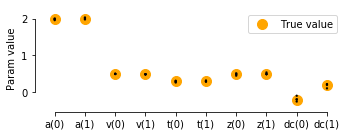

In [299]:
# plot true vs recovered parameters:
x = np.arange(5) * 2
y0 = np.array([params0['a'], params0['v'], params0['t'], params0['z'], params0['dc']])
y1 = np.array([params1['a'], params1['v'], params1['t'], params1['z'], params1['dc']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_fitted, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Param value')
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()

/anaconda3/envs/hddm/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/hddm/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/hddm/lib/python3.6/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


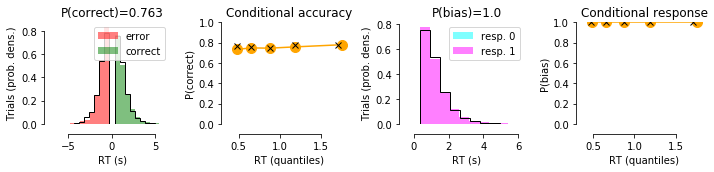

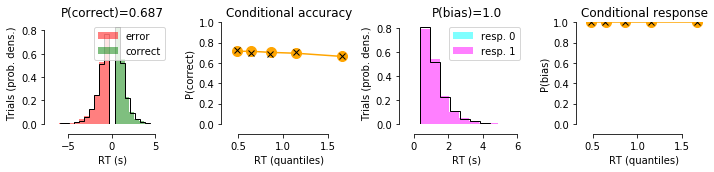

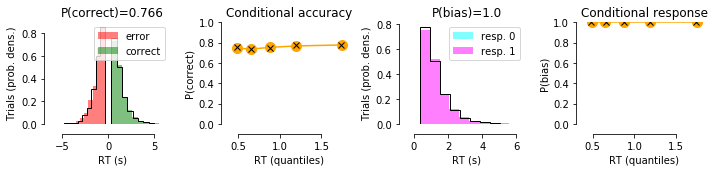

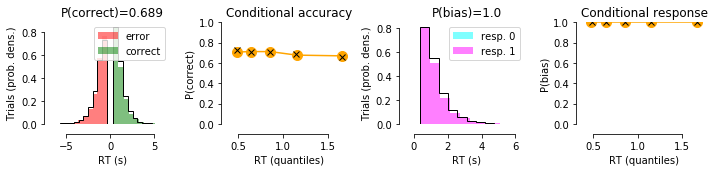

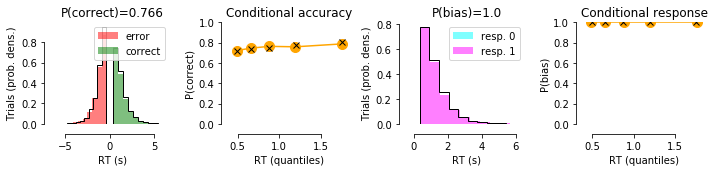

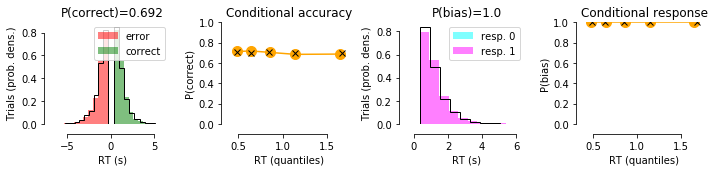

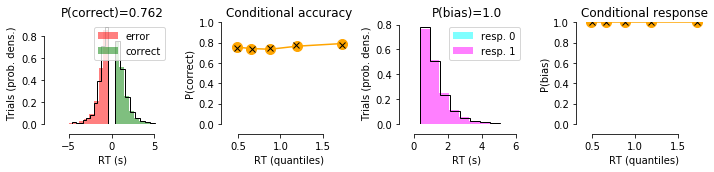

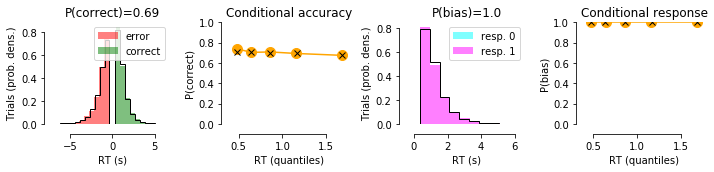

In [290]:
# plot data with model fit on top:
for s in np.unique(df_emp['subj_idx']):
    for c in np.unique(df_emp['condition']):
        summary_plot(df=df_emp.loc[(df_emp['subj_idx']==s)&(df_emp['condition']==c),:], 
                     df_sim=df_sim.loc[(df_emp['subj_idx']==s)&(df_emp['condition']==c),:])